# LSTM and Word Embeddings for Story Q/A
Yes/No Question Answering on the Facebook Babi dataset.

## Setup and Data Loading

In [ ]:
import pickle
import numpy as np
import pandas as pd

In [ ]:
with open('train_qa.txt','rb') as f:
  train_data = pickle.load(f)

with open('test_qa.txt','rb') as f:
  test_data = pickle.load(f)

In [ ]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [ ]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [ ]:
train_data[0][2]

'no'

In [ ]:
all_data = test_data + train_data
len(all_data)

11000

In [ ]:
set(train_data[0][0])

{'.',
 'Mary',
 'Sandra',
 'bathroom',
 'bedroom',
 'journeyed',
 'moved',
 'the',
 'to'}

## Creating a Vocabulary

In [ ]:
vocab=set()

for story,question,answer in all_data:
  vocab = vocab.union(set(story))
  vocab = vocab.union(set(question))

In [ ]:
vocab.add('no')
vocab.add('yes')

In [ ]:
' '.join(vocab)

'. office garden Sandra to football put discarded dropped Daniel the bathroom travelled apple John no journeyed went yes left in took hallway Is got ? Mary bedroom milk there grabbed kitchen picked back down moved up'

In [ ]:
vocab_len = len(vocab) + 1
vocab_len

38

## Setting up limits for the neural network

In [ ]:
# Longest story
all_story_lens = [len(data[0]) for data in all_data]
max_story_len = max(all_story_lens)
max_story_len

156

In [ ]:
max_question_len = max([len(data[1]) for data in all_data])
max_question_len

6

## Tokenization and Vetorization

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [ ]:
tokenizer.word_index

{'.': 1,
 '?': 26,
 'apple': 14,
 'back': 34,
 'bathroom': 12,
 'bedroom': 28,
 'daniel': 10,
 'discarded': 8,
 'down': 35,
 'dropped': 9,
 'football': 6,
 'garden': 3,
 'got': 25,
 'grabbed': 31,
 'hallway': 23,
 'in': 21,
 'is': 24,
 'john': 15,
 'journeyed': 17,
 'kitchen': 32,
 'left': 20,
 'mary': 27,
 'milk': 29,
 'moved': 36,
 'no': 16,
 'office': 2,
 'picked': 33,
 'put': 7,
 'sandra': 4,
 'the': 11,
 'there': 30,
 'to': 5,
 'took': 22,
 'travelled': 13,
 'up': 37,
 'went': 18,
 'yes': 19}

In [ ]:
train_story_text = []
train_question_text = []
train_answers = []

In [ ]:
for story,question,answer in train_data:
  train_story_text.append(story)
  train_question_text.append(question)
  train_answers.append(answer)

# train_story_text

In [ ]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)
len(train_story_seq)

10000

In [ ]:
def vectorize_stories(data,word_index = tokenizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):

  X = [] #Stories
  Xq = [] #Questions
  Y = [] #Answers(yes/no)

  for story,query,answer in data:

    x = [word_index[word.lower()] for word in story]
    xq = [word_index[word.lower()] for word in query]
    y = np.zeros(len(word_index)+1)
    y[word_index[answer]] = 1

    X.append(x)
    Xq.append(xq)
    Y.append(y)
  
  return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len),np.array(Y))

In [ ]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [ ]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [ ]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 503.,   0.,   0., 497.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

## DL Setup

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [ ]:
input_sequence = Input(shape=(max_story_len,))
question = Input((max_question_len,))

In [ ]:
vocab_size = len(vocab) + 1

In [ ]:
# Input encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# Output:
# (samples,story_max_len,embedding_dim)

In [ ]:
# Input encoder C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

# Output:
# (samples,story_maxlen,max_question_len)

In [ ]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_question_len))
question_encoder.add(Dropout(0.3))

# Output:
# (samples,query_maxlen,embedding_dim)

In [ ]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [ ]:
match = dot([input_encoded_m,question_encoded], axes=(2,2))
match = Activation('softmax')(match)

In [ ]:
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [ ]:
answer = concatenate([response,question_encoded])
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_1')>

In [ ]:
answer = LSTM(32)(answer)

In [ ]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer) # (samples, vocab_size)

In [ ]:
answer = Activation('softmax')(answer)

In [ ]:
model = Model([input_sequence,question],answer)

In [ ]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [ ]:
history = model.fit([inputs_train,queries_train],answers_train,batch_size=32,epochs=10,validation_data=([inputs_test,queries_test],answers_test))

Epoch 1/10
313/313 [==============================] - 9s 19ms/step - loss: 0.9254 - accuracy: 0.4835 - val_loss: 0.6946 - val_accuracy: 0.4970
Epoch 2/10
313/313 [==============================] - 5s 16ms/step - loss: 0.7028 - accuracy: 0.4989 - val_loss: 0.6939 - val_accuracy: 0.4970
Epoch 3/10
313/313 [==============================] - 5s 16ms/step - loss: 0.6957 - accuracy: 0.5043 - val_loss: 0.6937 - val_accuracy: 0.5030
Epoch 4/10
313/313 [==============================] - 5s 15ms/step - loss: 0.6944 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 5/10
313/313 [==============================] - 5s 16ms/step - loss: 0.6948 - accuracy: 0.4983 - val_loss: 0.6941 - val_accuracy: 0.4970
Epoch 6/10
313/313 [==============================] - 5s 15ms/step - loss: 0.6951 - accuracy: 0.4974 - val_loss: 0.6969 - val_accuracy: 0.4970
Epoch 7/10
313/313 [==============================] - 5s 15ms/step - loss: 0.6946 - accuracy: 0.4971 - val_loss: 0.6942 - val_accuracy: 0.4970

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


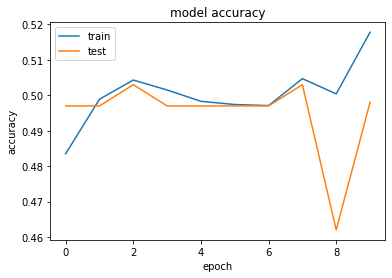

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
model.save('chatbotnew.h5')

Loading a model trained with more epochs

In [ ]:
model.load_weights('chatbot_10.h5')

## Testing the chatbot

In [ ]:
pred_results = model.predict(([inputs_test,queries_test]))

In [ ]:
pred_results.shape

(1000, 38)

In [ ]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [ ]:
test_data[0][1]

['Is', 'John', 'in', 'the', 'kitchen', '?']

In [ ]:
test_data[0][2]

'no'

In [ ]:
val_max = np.argmax(pred_results[0])

Converting token to answer
(The football if statement is due to the loaded model being trained on a slightly different token-word dictionary in which the tokens for `football` and `no` were exchanged'

In [ ]:
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key
    if (k=='football'):
      k='no'

In [ ]:
k

'no'

In [ ]:
my_story = "John left the kitchen . Sandra dropped the milk in the garden ."

In [ ]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'milk',
 'in',
 'the',
 'garden',
 '.']

In [ ]:
my_question = "Is the milk in the kitchen ?"
my_question.split()

['Is', 'the', 'milk', 'in', 'the', 'kitchen', '?']

In [ ]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [ ]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [ ]:
pred_res = model.predict(([my_story,my_ques]))

In [ ]:
val_max = np.argmax(pred_res[0])
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key
    if (k=='football'):
      k='no'

In [ ]:
k

'no'

Works :)

In [ ]:
pred_res[0][val_max]

0.9997731